In [25]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.src.layers import Rescaling
from sklearn.metrics import f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
import shutil
from sklearn.metrics import f1_score

base_dir = 'Images'

train_dir = 'train'
test_dir = 'test'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
if os.path.exists(test_dir):
    shutil.rmtree(test_dir)

os.makedirs(os.path.join(train_dir, 'glasses'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'no_glasses'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'glasses'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'no_glasses'), exist_ok=True)


def split_dataset(source_dir, train_dir, test_dir, split_ratio=0.5):
    for class_name in ['glasses', 'no_glasses']:
        source_class_dir = os.path.join(base_dir, class_name)
        train_class_dir = os.path.join(train_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)

        images = [
            img_name for img_name in os.listdir(source_class_dir)
            if os.path.isfile(os.path.join(source_class_dir, img_name)) and not img_name.startswith('.')
        ]
        random.shuffle(images)

        split_idx = int(len(images) * split_ratio)
        train_images = images[:split_idx]
        test_images = images[split_idx:]

        for img_name in train_images:
            src_path = os.path.join(source_class_dir, img_name)
            dest_path = os.path.join(train_class_dir, img_name)
            shutil.copy(src_path, dest_path)

        for img_name in test_images:
            src_path = os.path.join(source_class_dir, img_name)
            dest_path = os.path.join(test_class_dir, img_name)
            shutil.copy(src_path, dest_path)

split_dataset(base_dir, train_dir, test_dir)


'''
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(rescale=1./255)

def clean_checkpoints(directory):
    for root, dirs, _ in os.walk(directory):
        for dir_name in dirs:
            if dir_name == ".ipynb_checkpoints":
                shutil.rmtree(os.path.join(root, dir_name))
'''

'''
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary'
)
'''

train_experiment = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    batch_size=32,
)

test_experiment = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    batch_size=32,
)
classnames_train = train_experiment.class_names
classnames_test = test_experiment.class_names
print(classnames_train, classnames_test)





Found 2459 files belonging to 2 classes.
Found 2461 files belonging to 2 classes.
['glasses', 'no_glasses'] ['glasses', 'no_glasses']


# Data visualisation


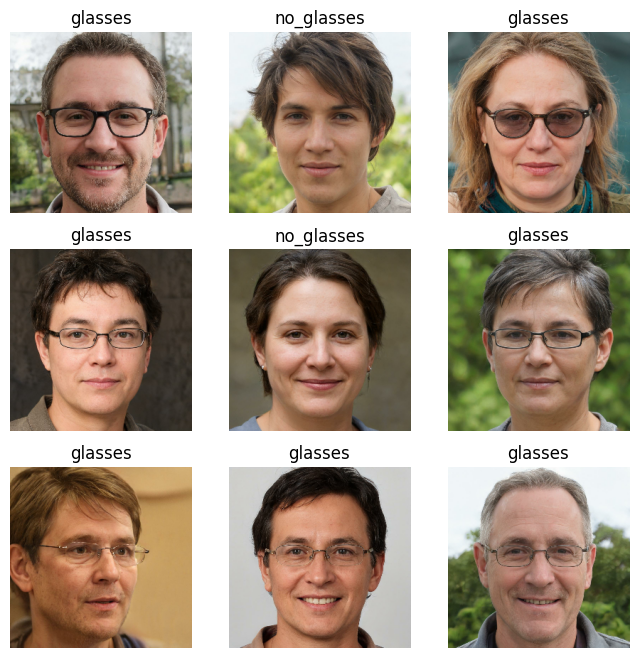

In [26]:
plt.figure(figsize=(8, 8))
for images, labels in train_experiment.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classnames_train[labels[i]])
        plt.axis("off")

# Data Optimisation

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
'''
def directory_to_dataset(directory_iterator):
    dataset = tf.data.Dataset.from_generator(
        lambda: directory_iterator,
        output_signature=(
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.float32)
        )
    )
    return dataset
'''
batch_size = 23
train_dataset = train_experiment.cache().shuffle(buffer_size=500).prefetch(buffer_size=3)
test_dataset = test_experiment.cache().prefetch(buffer_size=3)

data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip(
        "horizontal"),

    tf.keras.layers.RandomRotation(
        0.1),
    tf.keras.layers.RandomZoom(
        0.1),
  ]
)

# Tensorborad

In [28]:

# Load the TensorBoard notebook extension
#os.environ['TENSORBOARD_BINARY'] = 'C:/Users/vince/PycharmProjects/ProjetDataScientist/.venv/Lib/site-packages/tensorboard'
%load_ext tensorboard
import tensorflow as tf
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Model

In [35]:
def f1_score(y_true, y_pred):
    # Threshold predictions at 0.5
    y_pred = tf.cast(tf.greater(y_pred, 0.5), tf.float32)

    # Convert to float
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # True Positives
    true_positives = tf.reduce_sum(y_true * y_pred)

    # False Positives
    false_positives = tf.reduce_sum(tf.clip_by_value(y_pred - y_true, 0, 1))

    # False Negatives
    false_negatives = tf.reduce_sum(tf.clip_by_value(y_true - y_pred, 0, 1))

    # Precision
    precision = true_positives / (true_positives + false_positives + tf.keras.backend.epsilon())

    # Recall
    recall = true_positives / (true_positives + false_negatives + tf.keras.backend.epsilon())

    # F1 Score
    f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())

    return f1

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 59s 722ms/step - accuracy: 0.5254 - f1_score: 0.1292 - loss: 1.3444 - val_accuracy: 0.5689 - val_f1_score: 0.0200 - val_loss: 0.6769
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 51s 669ms/step - accuracy: 0.6069 - f1_score: 0.2913 - loss: 0.6624 - val_accuracy: 0.7233 - val_f1_score: 0.5127 - val_loss: 0.6387
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 51s 668ms/step - accuracy: 0.7810 - f1_score: 0.4101 - loss: 0.4754 - val_accuracy: 0.9638 - val_f1_score: 0.4203 - val_loss: 0.1070
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 53s 694ms/step - accuracy: 0.9603 - f1_score: 0.4351 - loss: 0.1276 - val_accuracy: 0.9931 - val_f1_score: 0.4400 - val_loss: 0.0282
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 54s 706ms/step - accuracy: 0.9847 - f1_score: 0.4442 - loss: 0.0657 - val_accuracy: 0.9959 - val_f1_score: 0.4391 - val_loss: 0.0158
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 51s 669ms/step - accuracy: 0.9728 - f1_score: 0.4304 - loss: 0.0904 - val_accuracy: 0.9959 - val_f1_score: 

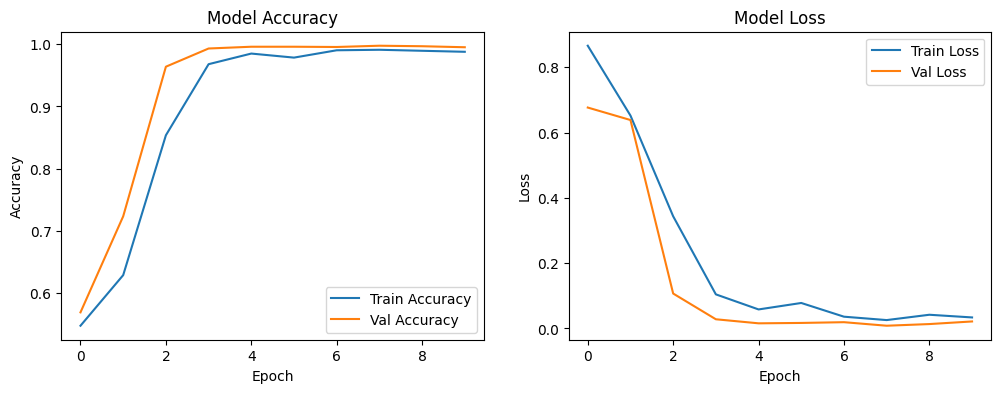

<Figure size 640x480 with 0 Axes>

Modèle sauvegardé avec succès.


In [42]:

model = Sequential([
    data_augmentation,
    Rescaling(1./255),
    Conv2D(16, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', #tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy', f1_score])

history = model.fit(
    #train_experiment,
    train_dataset,
    epochs=10,
    validation_data=test_dataset,
)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.tight_layout()
plt.show()

model.save("glasses_classification_model.keras")
print("Modèle sauvegardé avec succès.")


In [44]:
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,130,341 (42.46 MB)

 Trainable params: 3,710,113 (14.15 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 7,420,228 (28.31 MB)

# Save h5

In [45]:
model.save("glasses_classification_model.h5")